* https://www.kaggle.com/ntnu-testimon/paysim1

In [3]:
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import missingno as msno
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

%matplotlib inline

In [4]:
# timing helper functions

def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print("Toc: start time not set")

In [5]:
# don't need this for scikit learn, just set njobs = ncores

# set up parallel cluster using ipyparallel engines.
# ipcluster start
#import ipyparallel as ipp
#from ipyparallel import require
#c = ipp.Client(profile='default')
#v = c[:]
##print("engines running:",v)
#print("engines running:",len(v))

In [6]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [7]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.6,C1231006815,170136.0,160296.4,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.3,C1666544295,21249.0,19384.7,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.1,C2048537720,41554.0,29885.9,M1230701703,0.0,0.0,0,0


In [8]:
data.shape

(6362620, 11)

Elapsed time is 2.1075267791748047 seconds.


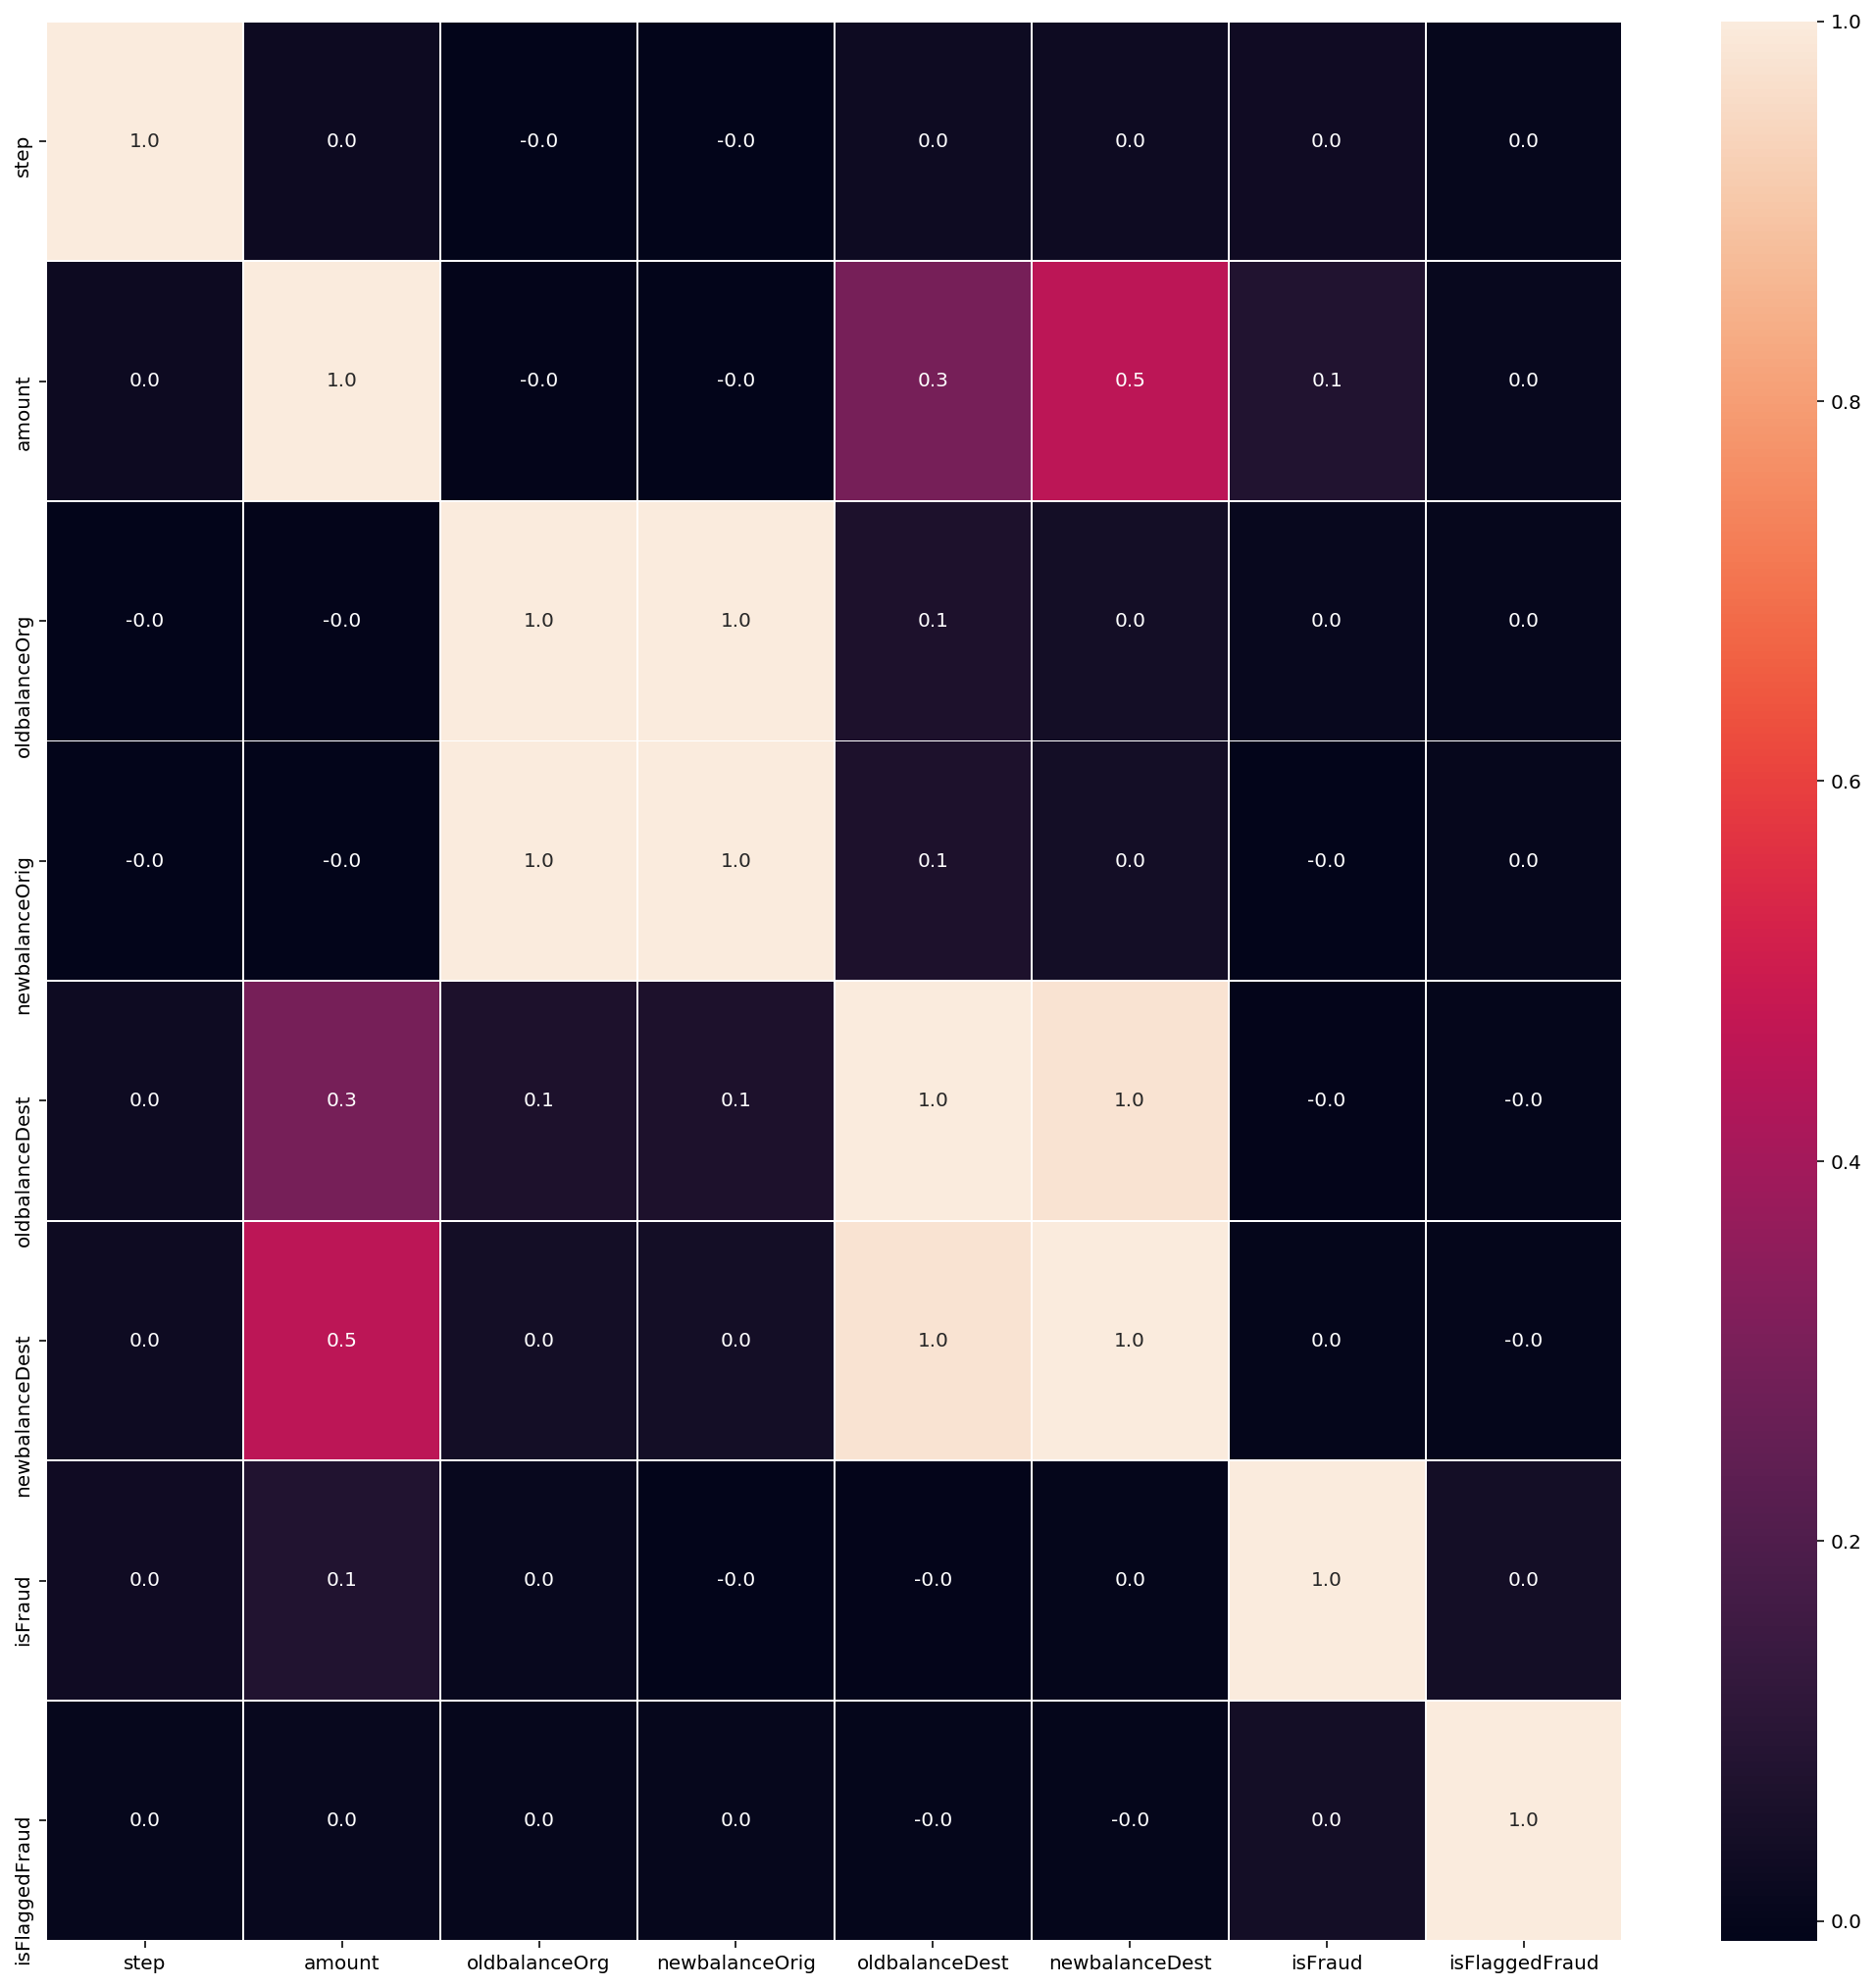

In [9]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

In [10]:
#look at class imbalance
by_class = data.groupby('isFraud')
by_class.describe()

step                                            amount            \
            count  mean   std min   25%   50%   75%   max     count      mean   
isFraud                                                                         
0       6354407.0 243.2 142.1 1.0 156.0 239.0 334.0 718.0 6354407.0  178197.0   
1          8213.0 368.4 216.4 1.0 181.0 367.0 558.0 743.0    8213.0 1467967.3   

         ... newbalanceDest             isFlaggedFraud                       \
         ...            75%         max          count mean std min 25% 50%   
isFraud  ...                                                                  
0        ...      1111975.3 356179278.9      6354407.0  0.0 0.0 0.0 0.0 0.0   
1        ...      1058725.2 236726494.7         8213.0  0.0 0.0 0.0 0.0 0.0   

                 
        75% max  
isFraud          
0       0.0 0.0  
1       0.0 1.0  

[2 rows x 56 columns]

In [11]:
#look at class imbalance
by_class = data.groupby('isFlaggedFraud')
by_class.describe()

step                                              amount  \
                   count  mean   std   min   25%   50%   75%   max     count   
isFlaggedFraud                                                                 
0              6362604.0 243.4 142.3   1.0 156.0 239.0 335.0 743.0 6362604.0   
1                   16.0 537.6 181.9 212.0 415.5 601.5 678.8 741.0      16.0   

                          ... newbalanceDest               isFraud           \
                    mean  ...            75%         max     count mean std   
isFlaggedFraud            ...                                                 
0               179850.1  ...      1111914.1 356179278.9 6362604.0  0.0 0.0   
1              4861597.7  ...            0.0         0.0      16.0  1.0 0.0   

                                    
               min 25% 50% 75% max  
isFlaggedFraud                      
0              0.0 0.0 0.0 0.0 1.0  
1              1.0 1.0 1.0 1.0 1.0  

[2 rows x 56 columns]

In [12]:
data.groupby('type')['isFraud','isFlaggedFraud'].sum()

,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


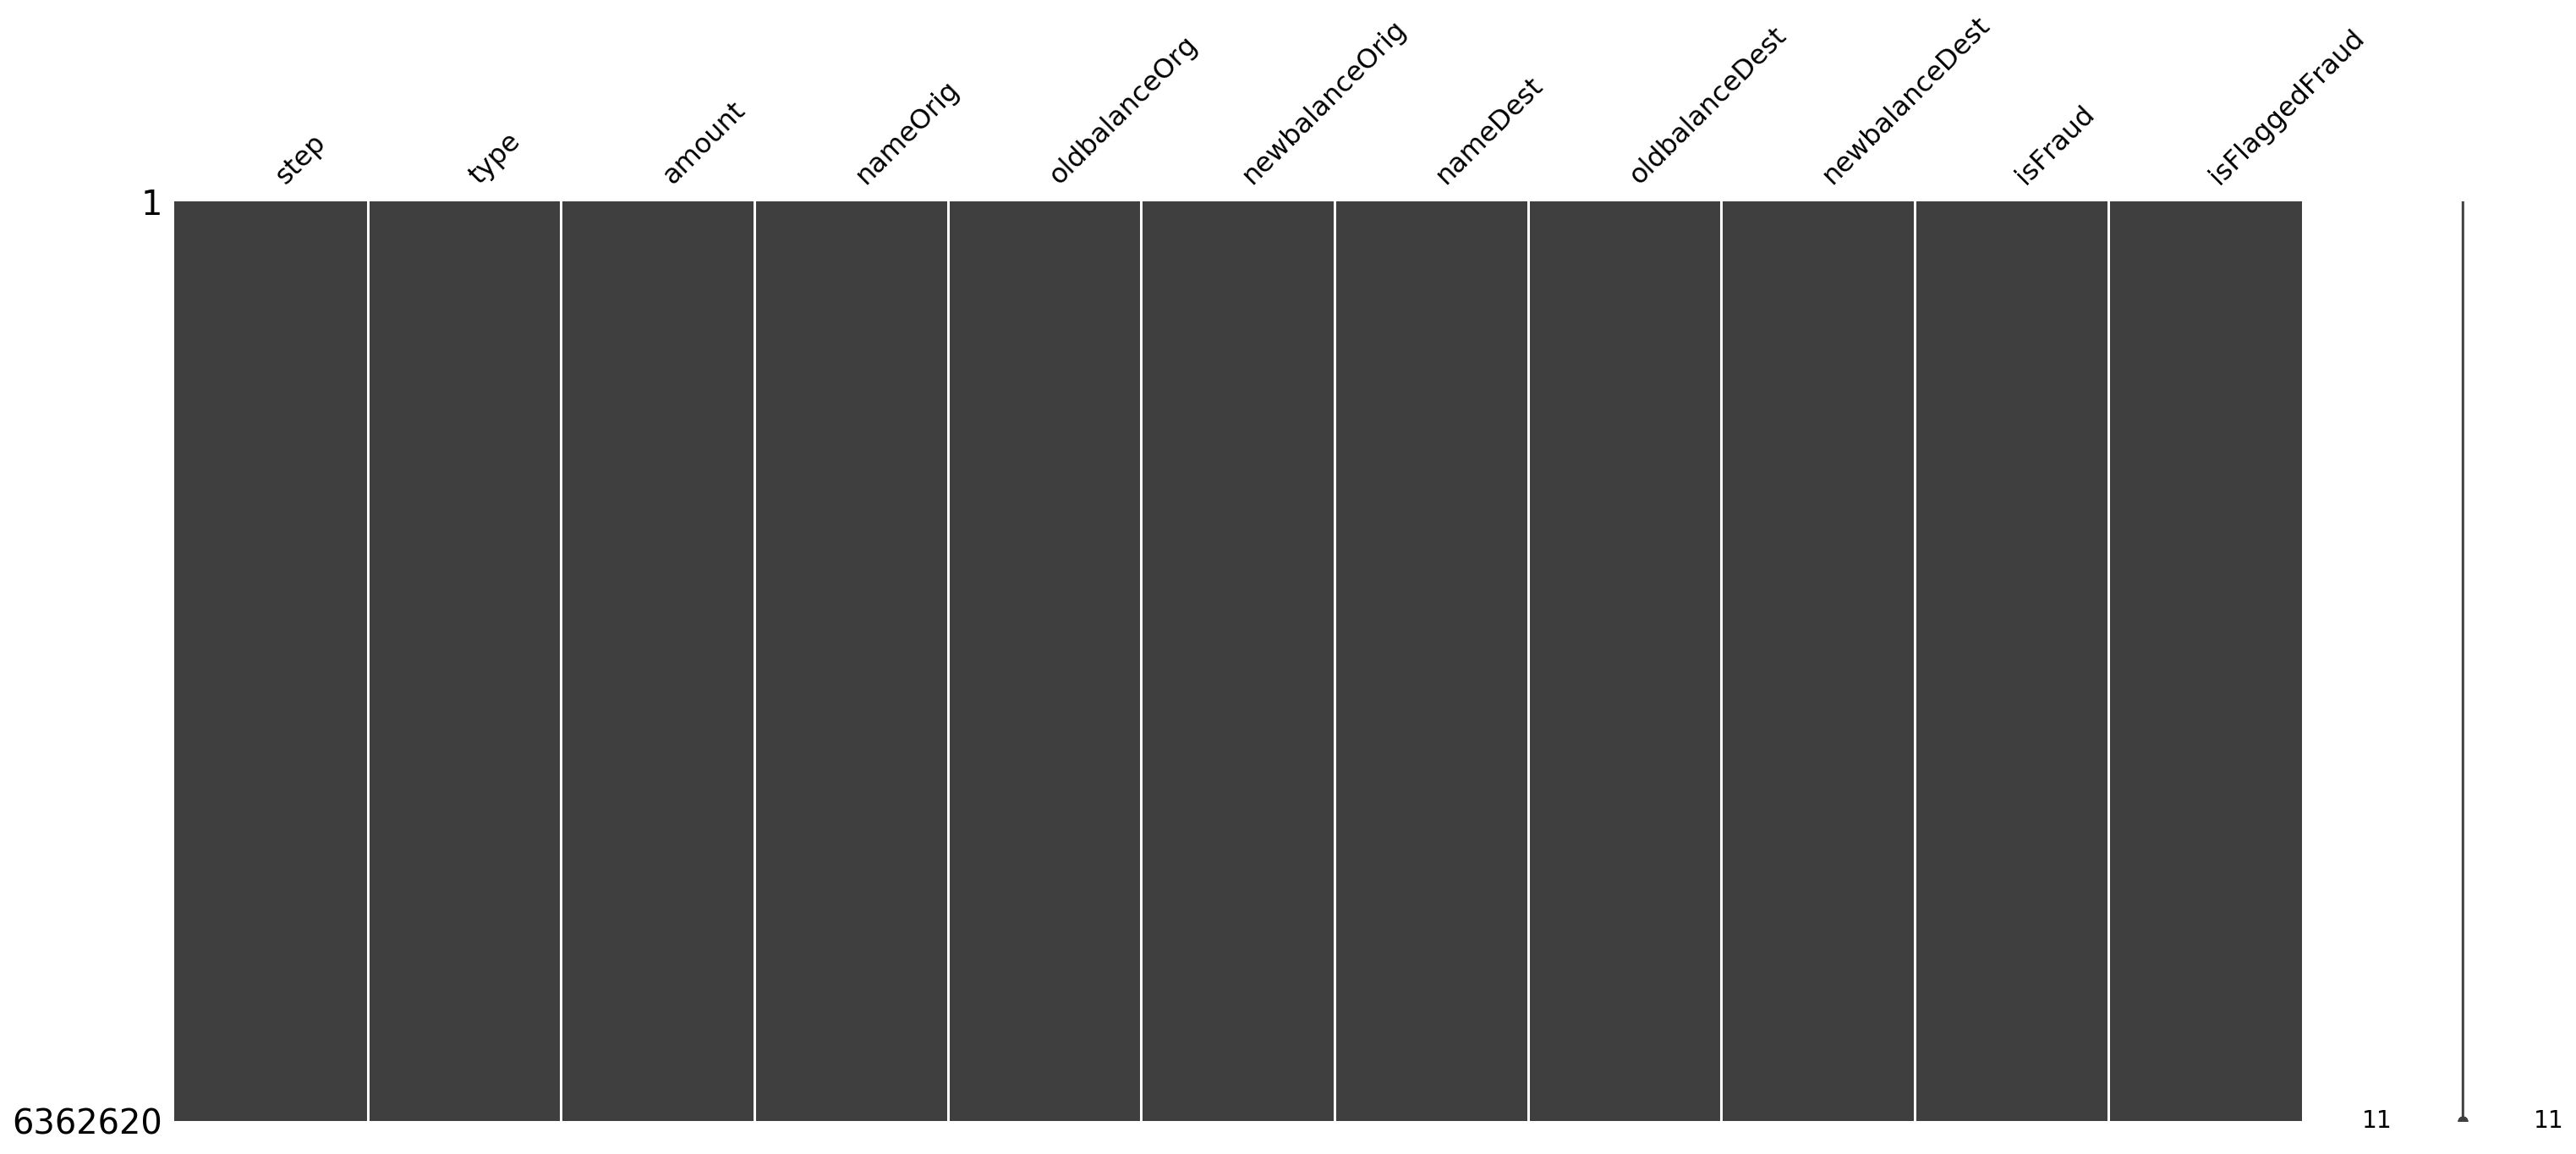

In [13]:
msno.matrix(data); # looks like no missing values

### Normalise the data

In [14]:
norm_step = np.array(data['step'])
norm_amount = np.array(data['amount'])
norm_newbalanceOrig = np.array(data['newbalanceOrig'])
norm_newbalanceDest = np.array(data['newbalanceDest'])

norm_step = StandardScaler().fit_transform(norm_step.reshape(-1,1))
norm_amount = StandardScaler().fit_transform(norm_step.reshape(-1,1))
norm_newbalanceOrig = StandardScaler().fit_transform(norm_newbalanceOrig.reshape(-1,1))
norm_newbalanceDest = StandardScaler().fit_transform(norm_newbalanceDest.reshape(-1,1))

/Users/scheckley/miniconda3/envs/machine-learning/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/scheckley/miniconda3/envs/machine-learning/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
data['norm_step'] = norm_step
data['norm_amount'] = norm_amount
data['norm_newbalanceOrig'] = norm_newbalanceOrig
data['norm_newbalanceDest'] = norm_newbalanceDest

In [16]:
# encode the transaction type
# http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
cols_to_transform = ['type']
type_hash = pd.get_dummies(data=data['type'])
#data['type_hash'] = type_hash

In [17]:
data = pd.concat([data, type_hash], axis=1)

del data['step']
del data['amount']
del data['newbalanceOrig']
del data['newbalanceDest']
del data['nameOrig']
del data['nameDest']
del data['type']

In [18]:
data.head(10)

,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,norm_step,norm_amount,norm_newbalanceOrig,norm_newbalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,170136.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
1,21249.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
2,181.0,0.0,1,0,-1.7,-1.7,-0.3,-0.3,0,0,0,0,1
3,181.0,21182.0,1,0,-1.7,-1.7,-0.3,-0.3,0,1,0,0,0
4,41554.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
5,53860.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
6,183195.0,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
7,176087.2,0.0,0,0,-1.7,-1.7,-0.2,-0.3,0,0,0,1,0
8,2671.0,0.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,0,1,0
9,41720.0,41898.0,0,0,-1.7,-1.7,-0.3,-0.3,0,0,1,0,0


Elapsed time is 4.879238128662109 seconds.


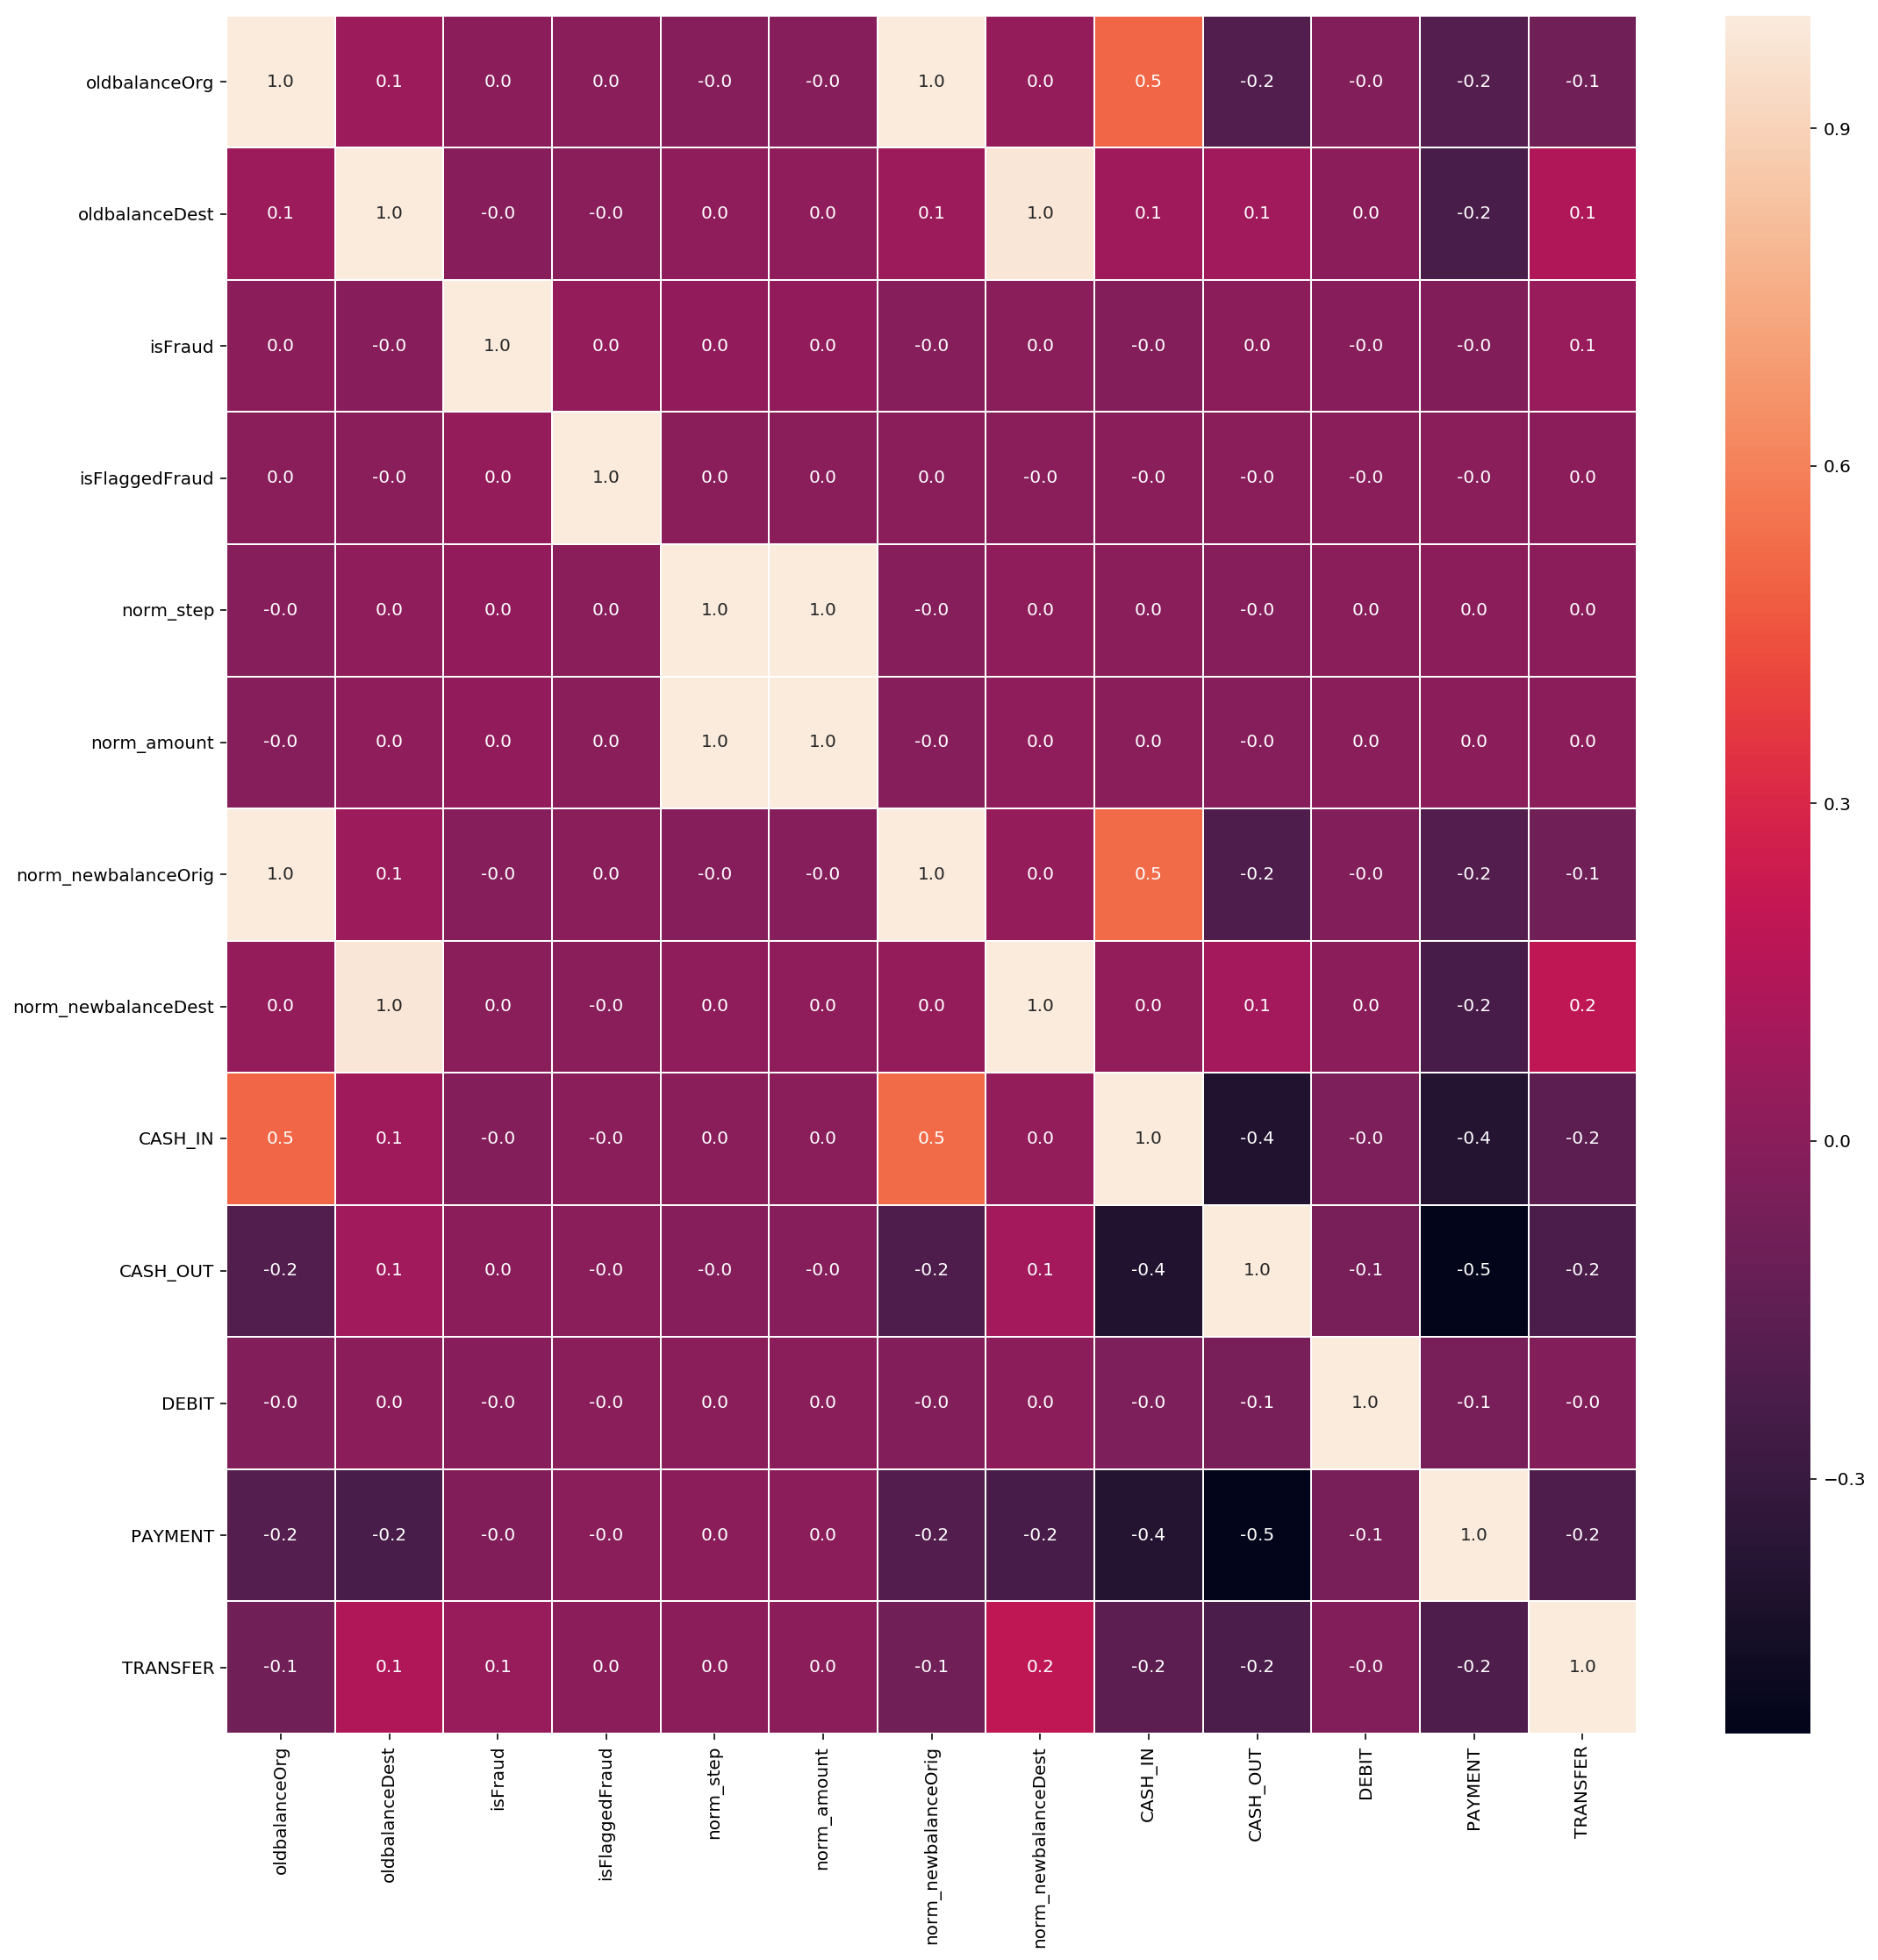

In [19]:
# heat map to look for correlation
tic()
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax);
toc()

In [20]:
#https://umap-learn.readthedocs.io/en/latest/index.html

#import umap
#reducer = umap.UMAP()

#embedding = reducer.fit_transform(data)
#embedding.shape

#plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in data])
#plt.gca().set_aspect('equal', 'datalim')
#plt.title('UMAP projection', fontsize=12);

## Prepare the data for training

In [25]:
#randomize the data to be sure not to have any pathological ordering effects that might impact on gradient descent.
data = data.reindex(
    np.random.permutation(data.index))

In [26]:
#pickle.dump(data, open( "processed_data.pkl", "wb" ))

In [27]:
#data = pickle.load(open( "processed_data.pkl", "rb" ))

In [28]:
from imblearn.over_sampling import ADASYN#SMOTE
sm = ADASYN(n_jobs=-1)

In [29]:
# split the features and target vector for resampling
X = data.loc[:, data.columns != 'isFraud']
y = data.loc[:, data.columns == 'isFraud']

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [31]:
#resmaple just the training data and leave the test data untouched
tic()
#X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)
toc()
# this step takes a bit of time so I pickle the output

Elapsed time is 3.3855438232421875e-05 seconds.


In [32]:
#pickle.dump(X_train_resampled, open( "X_train_resampled.pkl", "wb" ))
#pickle.dump(y_train_resampled, open( "y_train_resampled.pkl", "wb" ))

In [33]:
X_train_resampled = pickle.load(open( "X_train_resampled.pkl", "rb" ))
y_train_resampled = pickle.load(open( "y_train_resampled.pkl", "rb" ))

### Visualize the resampling

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X)

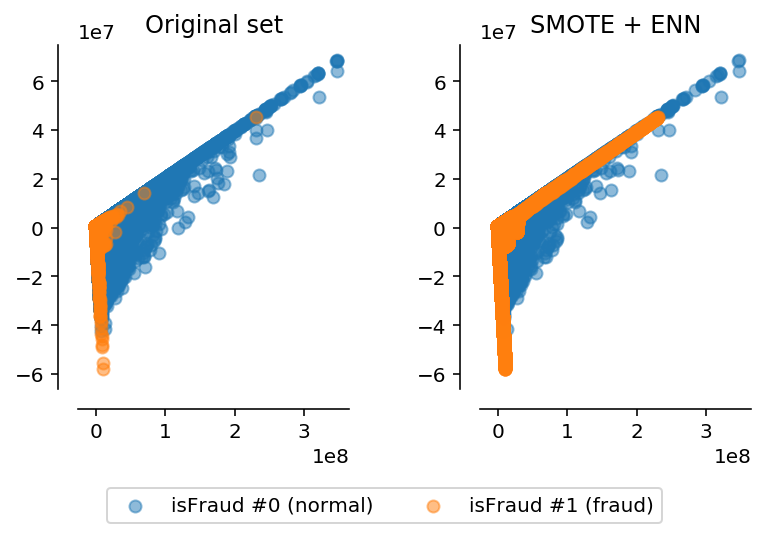

In [35]:
X_res_vis = pca.transform(X_train_resampled)

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(1, 2)

c0 = ax1.scatter(X_vis[y['isFraud'] == 0, 0], X_vis[y['isFraud'] == 0, 1], label="isFraud #0",
                 alpha=0.5)
c1 = ax1.scatter(X_vis[y['isFraud'] == 1, 0], X_vis[y['isFraud'] == 1, 1], label="isFraud #1",
                 alpha=0.5)
ax1.set_title('Original set')

ax2.scatter(X_res_vis[y_train_resampled == 0, 0], X_res_vis[y_train_resampled == 0, 1],
            label="isFraud #0", alpha=0.5)
ax2.scatter(X_res_vis[y_train_resampled == 1, 0], X_res_vis[y_train_resampled == 1, 1],
            label="isFraud #1", alpha=0.5)
ax2.set_title('SMOTE + ENN')

# make nice plotting
for ax in (ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    #ax.set_xlim([-10, 10])
    #ax.set_ylim([-10, 10])

f.legend((c0, c1), ('isFraud #0 (normal)', 'isFraud #1 (fraud)'), loc='lower center',
         ncol=2, labelspacing=0.)
plt.tight_layout(pad=3)
plt.show()

## Machine learning

In [37]:
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.externals import joblib #for saving the trained model

In [38]:
# rescale the data
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler() 
scaler.fit(X_train_resampled)
X_train = scaler.transform(X_train_resampled)  
X_test = scaler.transform(X_test) 

/Users/scheckley/miniconda3/envs/machine-learning/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [39]:
import itertools

# confusion matrix plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
# roc plot function

from sklearn.metrics import roc_curve, auc

def plot_roc_auc(actual, preds):
    fpr, tpr, thresholds = roc_curve(actual, preds[:,1])
    plt.plot(fpr, tpr,'r')
    plt.plot([0,1],[0,1],'b')
    plt.title('AUC: {}'.format(auc(fpr,tpr)))
    plt.show()

### Feature selection

In [48]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
# Create the RFE object and rank each pixel
clf_rf = RandomForestClassifier(n_estimators=100)      
rfe = RFE(estimator=clf_rf, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train_resampled[0:100000], y_train_resampled[0:100000])
print('Chosen best 5 feature by rfe:',X.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['oldbalanceOrg', 'norm_step', 'norm_amount', 'norm_newbalanceOrig',
       'norm_newbalanceDest'],
      dtype='object')


Text(0, 0.5, 'explained_variance_ratio_')

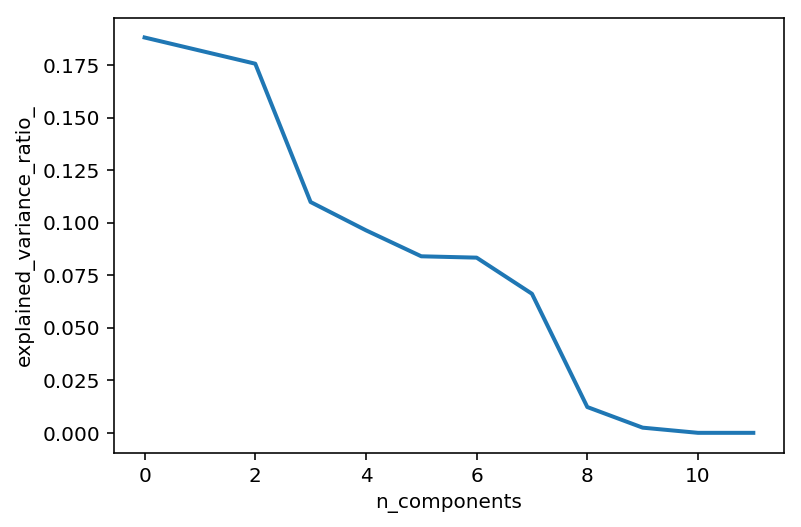

In [49]:
from sklearn.decomposition import PCA
#normalization
xtrain_norm = (X_train-X_train.mean())/(X_train.max()-X_train.min())
xtest_norm = (X_test-X_test.mean())/(X_test.max()-X_test.min())

pca = PCA(n_components=12) # set number of components to plot table below
pca.fit(xtrain_norm)

plt.figure()
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_2 = RandomForestClassifier(n_estimators=100) 
rfecv = RFECV(estimator=clf_rf_2, step=1, cv=10,scoring='accuracy')   #10-fold cross-validation
rfecv = rfecv.fit(X_train_resampled[0:100000], y_train_resampled[0:100000])

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X.columns[rfecv.support_])

In [ ]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
# everything looks useful in this dataset

### Logistic regression

In [52]:
# try a grid search to find best parameters

#from sklearn.model_selection import GridSearchCV
#tic()
#lr = LogisticRegression(C = 0.01, penalty = 'l1')# , solver='liblinear')
#grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 'fit_intercept' : [True, False]}
#lr = GridSearchCV(lr, param_grid=grid_values, n_jobs=-1)
#lr.fit(X_train,y_train_resampled)
#print(lr.best_params_)

#y_pred = lr.predict(X_test)
#toc()

the above takes 12 hours on a Power8 cluster so I ran the gridsearch on the hpc and load the model from a joblib dump:

In [ ]:
lr = joblib.load('lr_model.pkl')

In [54]:
print(lr.best_params_)

{'C': 10, 'fit_intercept': True, 'penalty': 'l2'}


In [55]:
ac = accuracy_score(y_test,lr.predict(X_test))
print('Accuracy is: ',ac)

Accuracy is:  0.9583552058743097


In [56]:
y_pred = lr.predict(X_test)
ac = accuracy_score(y_test,lr.predict(X_test))
print('Accuracy is: ',ac)

Accuracy is:  0.9583552058743097


Recall metric in the testing dataset:  0.9559823929571829


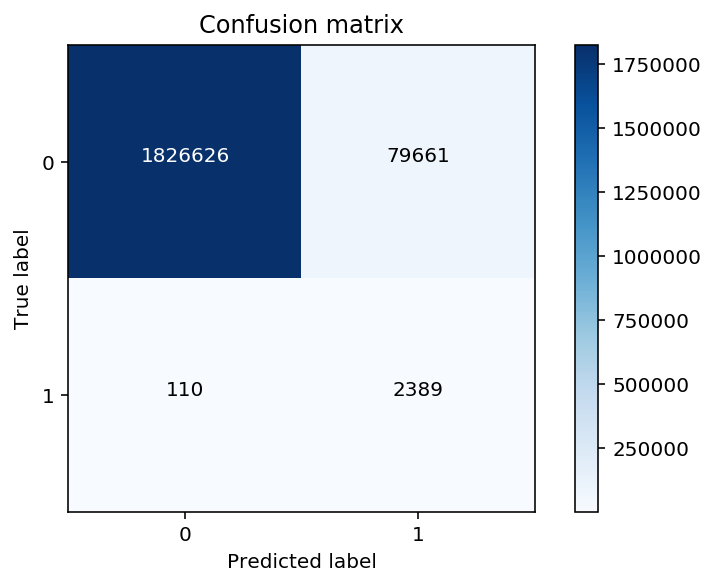

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

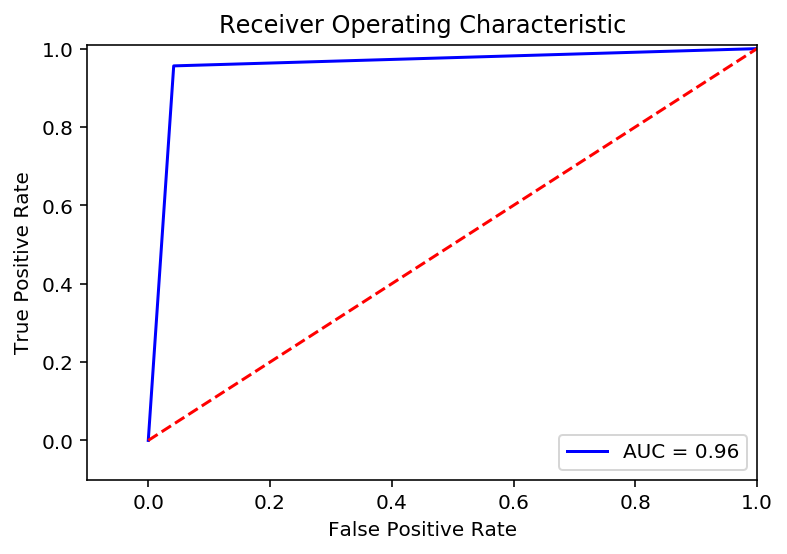

In [35]:
# ROC curve
lr = LogisticRegression(C = 100, penalty = 'l2', fit_intercept=True)
y_pred_score = lr.fit(X_train,y_train_resampled).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Not too bad, can we do better?

### Stochastic Gradient Descent

* http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4

In [40]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 115.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 183.3min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 305.7min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 375.7min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed: 489.5min remaining: 50.6min


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed: 497.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.5s finished


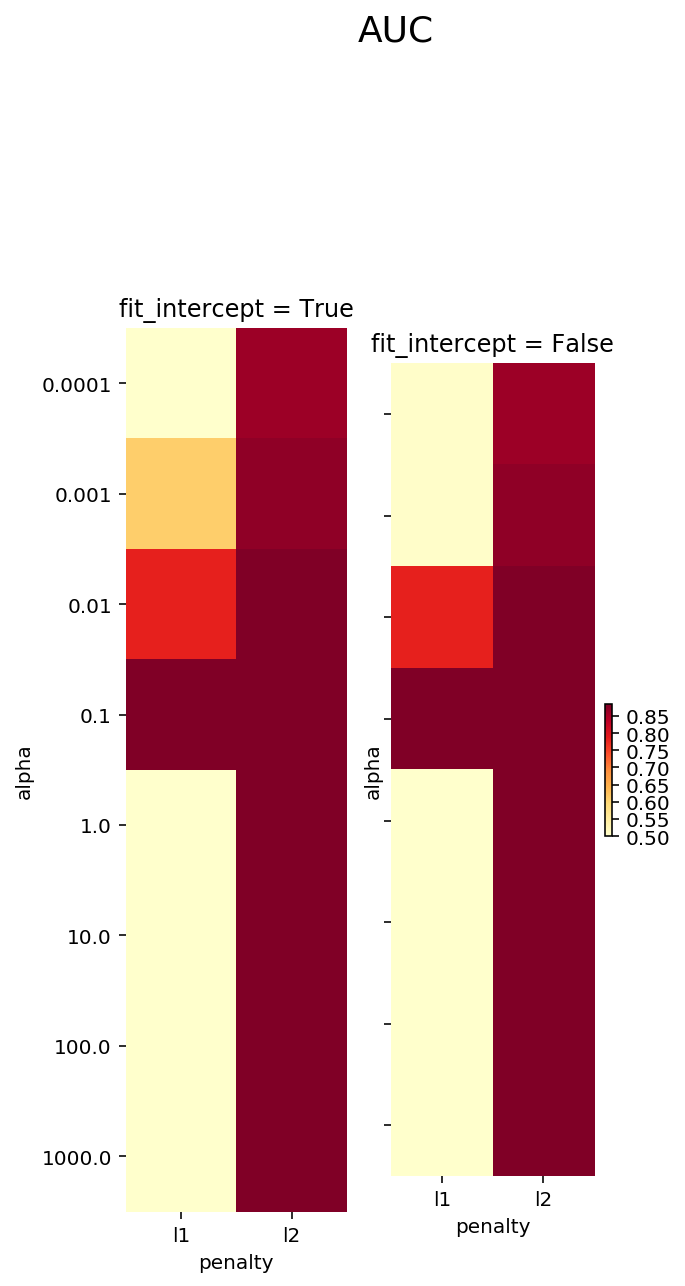

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=False, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=1000,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=8418,
       shuffle=True, tol=None, verbose=0, warm_start=False) 0.8862845647347806


In [32]:
# hyper parameter tuning with parfit instead of gridsearch

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],  # learning rate
    'n_iter': [1000],  # number of epochs
    'loss': ['log'],  # logistic regression,
    'penalty': ['l1', 'l2'],
    'fit_intercept': [True, False],
    'n_jobs': [-1],
    'random_state': [8418]
}
paramGrid = ParameterGrid(grid)

best_model, best_score, all_models, all_scores = pf.bestFit(
    SGDClassifier(),
    paramGrid,
    X_train,
    y_train_resampled,
    X_test,
    y_test,  # nfolds=5 [optional, instead of validation set]
    metric=roc_auc_score,
    greater_is_better=True,
    scoreLabel='AUC')

print(best_model, best_score)

/Users/scheckley/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


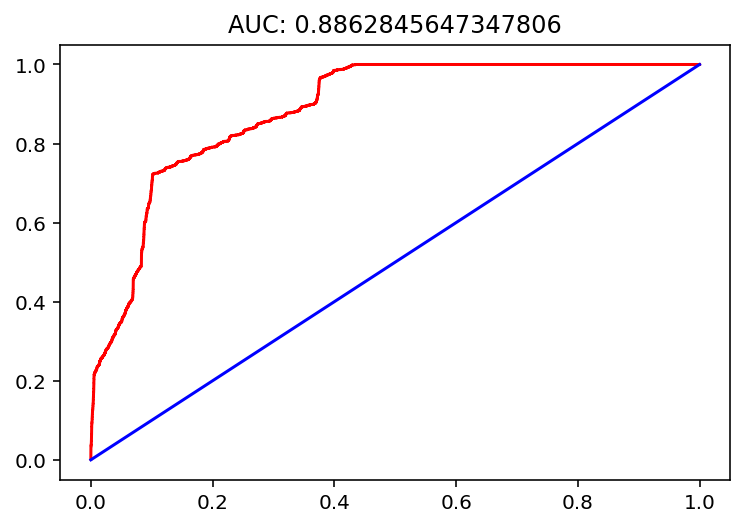

In [33]:
plot_roc_auc(y_test, best_model.predict_proba(X_test))

In [25]:
tic()

sgd = SGDClassifier(
    alpha=0.01,
    average=False,
    class_weight=None,
    epsilon=0.1,
    eta0=0.0,
    fit_intercept=False,
    l1_ratio=0.15,
    learning_rate='optimal',
    loss='log',
    max_iter=100,  #set this to 1000 for a full run
    n_jobs=-1,
    penalty='l2',
    power_t=0.5,
    random_state=8418,
    shuffle=True,
    tol=None,
    verbose=0,
    warm_start=False)

#grid_values = {'penalty': ['l1','l2', 'elasticnet'], 'alpha': [0.000001, 0.001,0.01,1], 'epsilon': [0.01,0.1,1]}

# grid search to find the best number of estimators
#sgd = GridSearchCV(sgd, param_grid=grid_values, n_jobs=-1)

sgd.fit(X_train, y_train_resampled)

y_pred = sgd.predict(X_test)

toc()

ac = accuracy_score(y_test,sgd.predict(X_test))
print('Accuracy is: ',ac)
#print('model accuracy =',sgd.score(X_test, y_test)*100,'%')

Elapsed time is 312.69119000434875 seconds.
Accuracy is:  0.7618779685098277


In [26]:
#save the model
joblib.dump(sgd, 'sgd_model.pkl')

['sgd_model.pkl']

Recall metric in the testing dataset:  0.8899559823929571


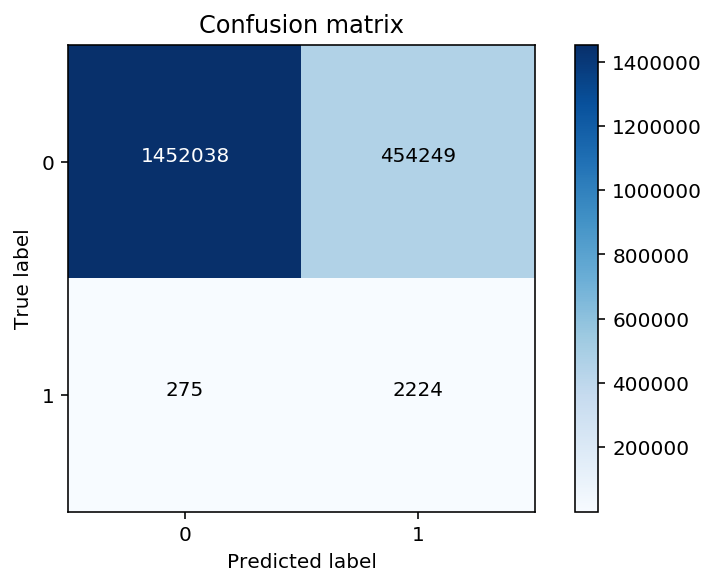

In [27]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ",
      cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(
    cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

89% - not too bad, but not as good as linear regression.

### XGBoost

In [41]:
import xgboost as xgb

In [45]:
reg = xgb.XGBRegressor(n_estimators=25, max_depth=12, learning_rate=0.1, subsample=1, colsample_bytree=0.9, random_state=8418, eval_metric='rmse',n_jobs=4)

In [46]:
tic()
reg.fit(X_train, y_train_resampled)

y_pred = reg.predict(X_test)
toc()

Elapsed time is 161.77862191200256 seconds.


In [47]:
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.47%


In [27]:
joblib.dump(reg, 'xgb_model.pkl')

['xgb_model.pkl']

In [ ]:
dat = confusion_matrix(y_test, predictions)

plot_confusion_matrix(
    dat, classes=[0,1], title='Confusion matrix')
plt.show()

Excellent. 98.5% accuracy with XGBoost and fitted in <10 minutes on a MacBook pro!  I think this is as good as it gets.

### Tensor flow

In [42]:
# https://towardsdatascience.com/from-scikit-learn-to-tensorflow-part-1-9ee0b96d4c85

# ------------------------------------------
# TensorFlow Implementation
# ------------------------------------------

import tensorflow as tf
# Extract the features from the training data
feats = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)

# Building a 7-layer hidden layer DNN comprising 20 units in each layer
classifier_tf = tf.contrib.learn.DNNClassifier(
    feature_columns=feats, hidden_units=[20,20,20,20,20,20,20], n_classes=2)

# Use the train data to train this classifier
classifier_tf.fit(
    X_train,
    y_train_resampled,
    steps=4000,
    batch_size=100)

# Use the trained model to predict on the test data
predictions = list(classifier_tf.predict(X_test, as_iterable=True))
score = metrics.accuracy_score(y_test, predictions)

Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a215cf978>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local',

In [43]:
score

0.6812560444177608

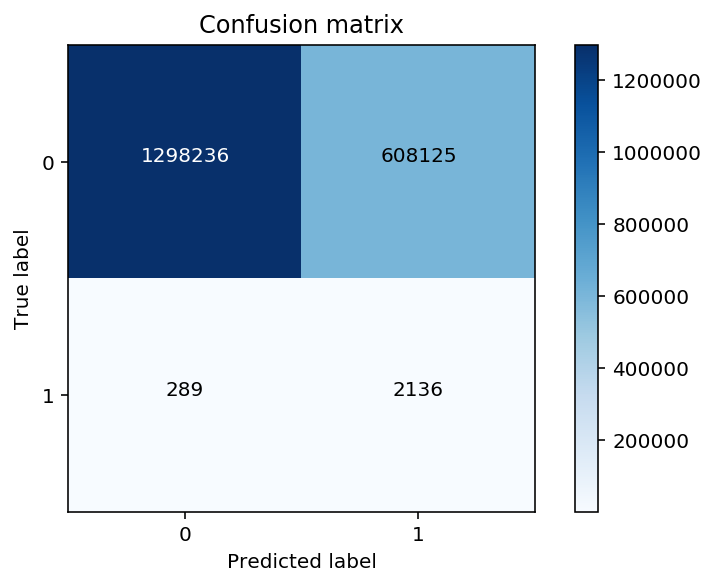

In [44]:
dat = confusion_matrix(y_test, predictions)

plot_confusion_matrix(
    dat, classes=[0,1], title='Confusion matrix')
plt.show()

### Keras

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [58]:
X_train_resampled.shape

(8897826, 12)

In [59]:
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    return model

In [ ]:
seed = 8418
model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)
# evaluate using 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(model, X_train_resampled, y_train_resampled, cv=kfold)
print(results.mean())